In [1]:
import pandas as pd
import tqdm
from matplotlib import  pyplot as plt
from src.geometric_algorithms.categorical_data import split_and_normalize, perform_regression_and_append_residuals, \
       normalize_and_split_dataframes, compute_bounds_for_all, dynamic_programming_1d
import numpy as np
plt.style.use('default')

In [2]:
from data.martinez import load_martinez_raw

# Load the martinez dataset
df, categorical_columns = load_martinez_raw(keep_all_country_categories=True)
# Determine the columns corresponding the main regressors in this study:
label = 'lngdp14'
feature_of_interest = 'lndn13_fiw'

In [3]:
# Split the dataframe into buckets corresponding to the categorical parameter:
bucket_dfs = split_and_normalize(df, categorical_columns)

# Perform a linear regression:
coefficients = perform_regression_and_append_residuals(bucket_dfs, label)
print(f"{feature_of_interest}:{coefficients[feature_of_interest]}")
beta_e = np.abs(coefficients[feature_of_interest])
beta_e_sign = np.sign(coefficients[feature_of_interest])

# Normalize the data and extract it from the dataframes into numpy arrays. 
split_X, split_R, axis_of_interest_normalized = normalize_and_split_dataframes(bucket_dfs, feature_of_interest, sign=beta_e_sign)
X = np.vstack(split_X)
residuals = np.concatenate(split_R)
num_samples, dimension = X.shape

# Compute a mapping from bucket index to upper bounds on its direct influences as a function of the number of samples removed from it:
bounds_list = compute_bounds_for_all(split_X, split_R, axis_of_interest_normalized)

# Use a dynamic programming algorithm to solve the integer knapsack to maximize the total direct influences
total_score_bounds = dynamic_programming_1d(bounds_list, num_samples // 10)[1:]

Separating by categorical columns: 100%|██████████| 184/184 [00:00<00:00, 290.07it/s]


Computing residuals...
lndn13_fiw:0.0216376472600985


Dynamic programming: 100%|██████████| 184/184 [00:01<00:00, 147.30it/s]


In [4]:
# Use an implementation of the AMIP algorithm to generate a baseline:

from data.martinez import load_martinez_XY
from src.lower_bounds.lower_bounds import compute_removal_effects
from src.lower_bounds.amip import approximate_most_influential_pertrubation
import numpy as np

# AMIP does not take into account the fact that we have are removing categorical features, so we need to reload the martinez dataset as is.
X_martinez, Y_martinez = load_martinez_XY()
coefficients, _, _, _ = np.linalg.lstsq(X_martinez, Y_martinez, rcond=None)
R_martinez = Y_martinez - (X_martinez @ coefficients)
axis_of_interest_martinez = np.concatenate((np.zeros(X_martinez.shape[1]-1), [1]))

ks = np.arange(1, num_samples // 10)
_, amip_gradients = approximate_most_influential_pertrubation(X_martinez, R_martinez, axis_of_interest_martinez)
order_amip = np.argsort(-amip_gradients)

removal_effect_amip = compute_removal_effects(X_martinez, R_martinez, axis_of_interest_martinez, order_amip, ks, normalized=False)

Computing removal effects: 100%|██████████| 388/388 [03:01<00:00,  2.14it/s]


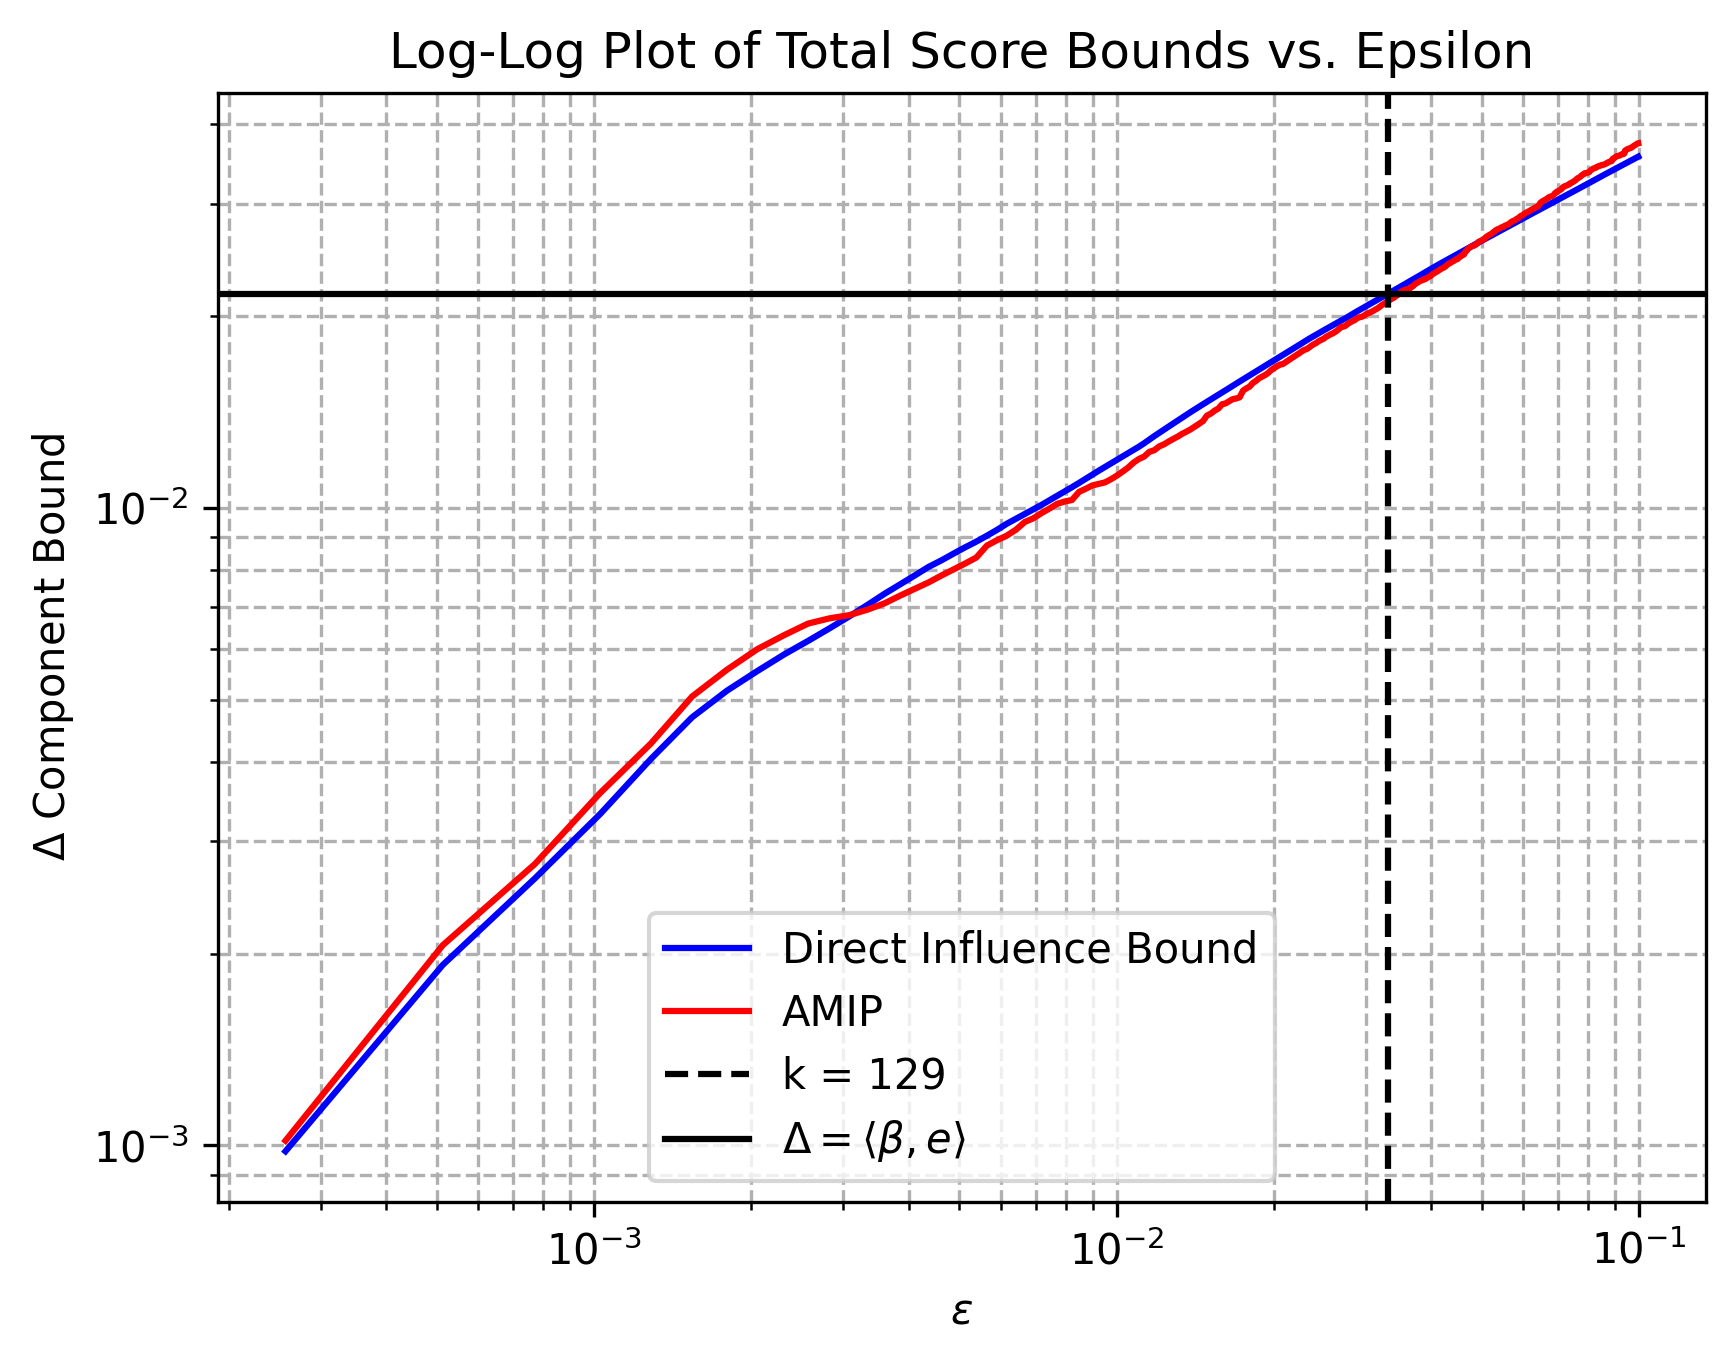

In [5]:
# Plot our bound on the direct influences, compared to the actual effects as measured by AMIP

epsilons =  ks/ num_samples

# Find the intersection
intersection_k = None
for k, score_bound in enumerate(total_score_bounds, start=1):
    if score_bound >= np.abs(beta_e):
        intersection_k = k
        break

# Plotting
plt.figure(dpi=300)
plt.loglog(epsilons, total_score_bounds[:len(epsilons)], '-b', label='Direct Influence Bound')
plt.loglog(epsilons, removal_effect_amip, '-r', label='AMIP')
plt.grid(True, which="both", ls="--")

if intersection_k:
    epsilon_intersection = intersection_k / num_samples
    plt.axvline(x=epsilon_intersection, color='k', linestyle='--', label=f'k = {intersection_k}')
    plt.axhline(y=np.abs(beta_e), color='k', linestyle='-', label=r'$\Delta = \langle \beta, e \rangle$')

plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$\Delta$ Component Bound')
plt.title('Log-Log Plot of Total Score Bounds vs. Epsilon')
plt.legend()
plt.show()


In [6]:
# Precomputations that will help us bound the effect of reaveraging on covariance shift terms
from src.geometric_algorithms.categorical_data import compute_XZ_XR_categorical
from src.geometric_algorithms.spectral_algorithms import spectral_bound_sum_ips_squared, spectral_bound_sum_ips
from src.geometric_algorithms.triangle_inequality import refined_triangle_inequality_ips, refined_triangle_inequality_ips_squared
# These are bounds on the norm of the sum of any $k$ members of any bucket: 
category_norm_bounds = [
    refined_triangle_inequality_ips(bucket @ bucket.T, verbose=False)
    for bucket in tqdm.tqdm(split_X, desc='Categorical triangle inequalities')
]
# In sum ips functions, we do not include the options for 0 or n removals
category_norm_bounds = [
    np.concatenate([[0], category_norm_bound, [0]]) for category_norm_bound in category_norm_bounds
]
# This probably won't change too much, but we can use the fact that the sum over all samples in a bucket is always 0, so max norm sum over k samples == max norm sum over n-k samples.
category_norm_bounds = [
    np.minimum(category_norm_bound, category_norm_bound[::-1]) for category_norm_bound in category_norm_bounds
]

Categorical triangle inequalities: 100%|██████████| 184/184 [00:00<00:00, 364.19it/s]


In [7]:
# Compute bounds on the covariance shift and problem 1s as with any dataset.
gram_matrix_CS = X @ X.transpose()
ips_squared_bound_triangle = refined_triangle_inequality_ips_squared(gram_matrix_CS)

averaging_effect_CS_bounds = [
    (category_norm_bound[:-1]**2) / (len(category_norm_bound) - 1 - np.arange(len(category_norm_bound) - 1)) for category_norm_bound in category_norm_bounds
]
averaging_effect_CS_total = dynamic_programming_1d(
    averaging_effect_CS_bounds, k_max=num_samples
)[1:]

# Here we try a different approach to bounding the Covariance shift with the averaging effect.
# Instead of relaxing by allowing our optimization to select different distributions of our removals amongst buckets,
# we enforce that we always remove the same number of samples from each bucket, but now relax to
# max_v sum_j sum_{i in B_j intersect T} <X_i, v>^2 <= sum_j max_{v_j} sum_{i in B_j intersect T} <X_i, v_j>^2 <=
# sum_j Norm{sum_{i in T intersect B_j} X_i tensor X_i 

# category_sum_ips_bounds = [
#     refined_triangle_inequality_ips_squared(bucket @ bucket.T, verbose=False)
#     for bucket in tqdm.tqdm(split_X, desc='Categorical triangle inequalities')
# ]
# # In sum ips functions, we do not include the options for 0 or n removals
# category_sum_ips_bounds = [
#     np.concatenate([[0], category_sum_ips_bound]) for category_sum_ips_bound in category_sum_ips_bounds
# ]
# 
# CS_DP_bound =  dynamic_programming_1d(
#     bounds_list=[
#         category_sum_ips_bound + category_norm_bound 
#         for category_sum_ips_bound, category_norm_bound in zip(category_sum_ips_bounds, averaging_effect_CS_bounds)
#     ], k_max=num_samples
# )[1:]

Dynamic programming: 100%|██████████| 184/184 [00:24<00:00,  7.53it/s]


In [8]:
# Generate a version of the Xe and XR arrays tailored to the categorical dataset
# XZ, XR = compute_XZ_XR_categorical(split_X, split_R, axis_of_interest_normalized)
XZ = X * (X @ axis_of_interest_normalized)[:, np.newaxis]
XR = X * residuals[:, np.newaxis]

highest_res_averages = [
    np.concatenate((np.zeros(1), np.maximum(
        np.abs(np.cumsum(np.sort(R_bucket))), np.abs(np.cumsum(np.sort(R_bucket)[::-1]))
    ) / np.arange(1, len(R_bucket)+1))) for R_bucket in split_R
]
averaging_effect_XR_bounds = [
    hra[::-1]  * cnb for hra, cnb in zip(highest_res_averages, category_norm_bounds)
]
averaging_effect_XR_total = dynamic_programming_1d(
    averaging_effect_XR_bounds, k_max=num_samples
)[1:]

split_Z = [bucket @ axis_of_interest_normalized for bucket in split_X]
highest_Z_averages = [
    np.concatenate((np.zeros(1), np.maximum(
        np.cumsum(np.sort(Z_bucket)), np.cumsum(np.sort(Z_bucket)[::-1])
    ) / np.arange(1, len(Z_bucket)+1))) for Z_bucket in split_Z
]
averaging_effect_Xe_bounds = [
    hza[::-1]  * cnb for hza, cnb in zip(highest_Z_averages, category_norm_bounds)
]

averaging_effect_Xe_total = dynamic_programming_1d(
    averaging_effect_Xe_bounds, k_max=num_samples
)[1:]

gram_matrix_XR = XR @ XR.transpose()
sum_ips_XR_triangle = refined_triangle_inequality_ips(gram_matrix=gram_matrix_XR)

gram_matrix_Xe = XZ @ XZ.transpose()
sum_ips_Xe_triangle = refined_triangle_inequality_ips(gram_matrix=gram_matrix_Xe)

Compiling triangle bounds: 100%|██████████| 3894/3894 [00:00<00:00, 4434.28it/s]


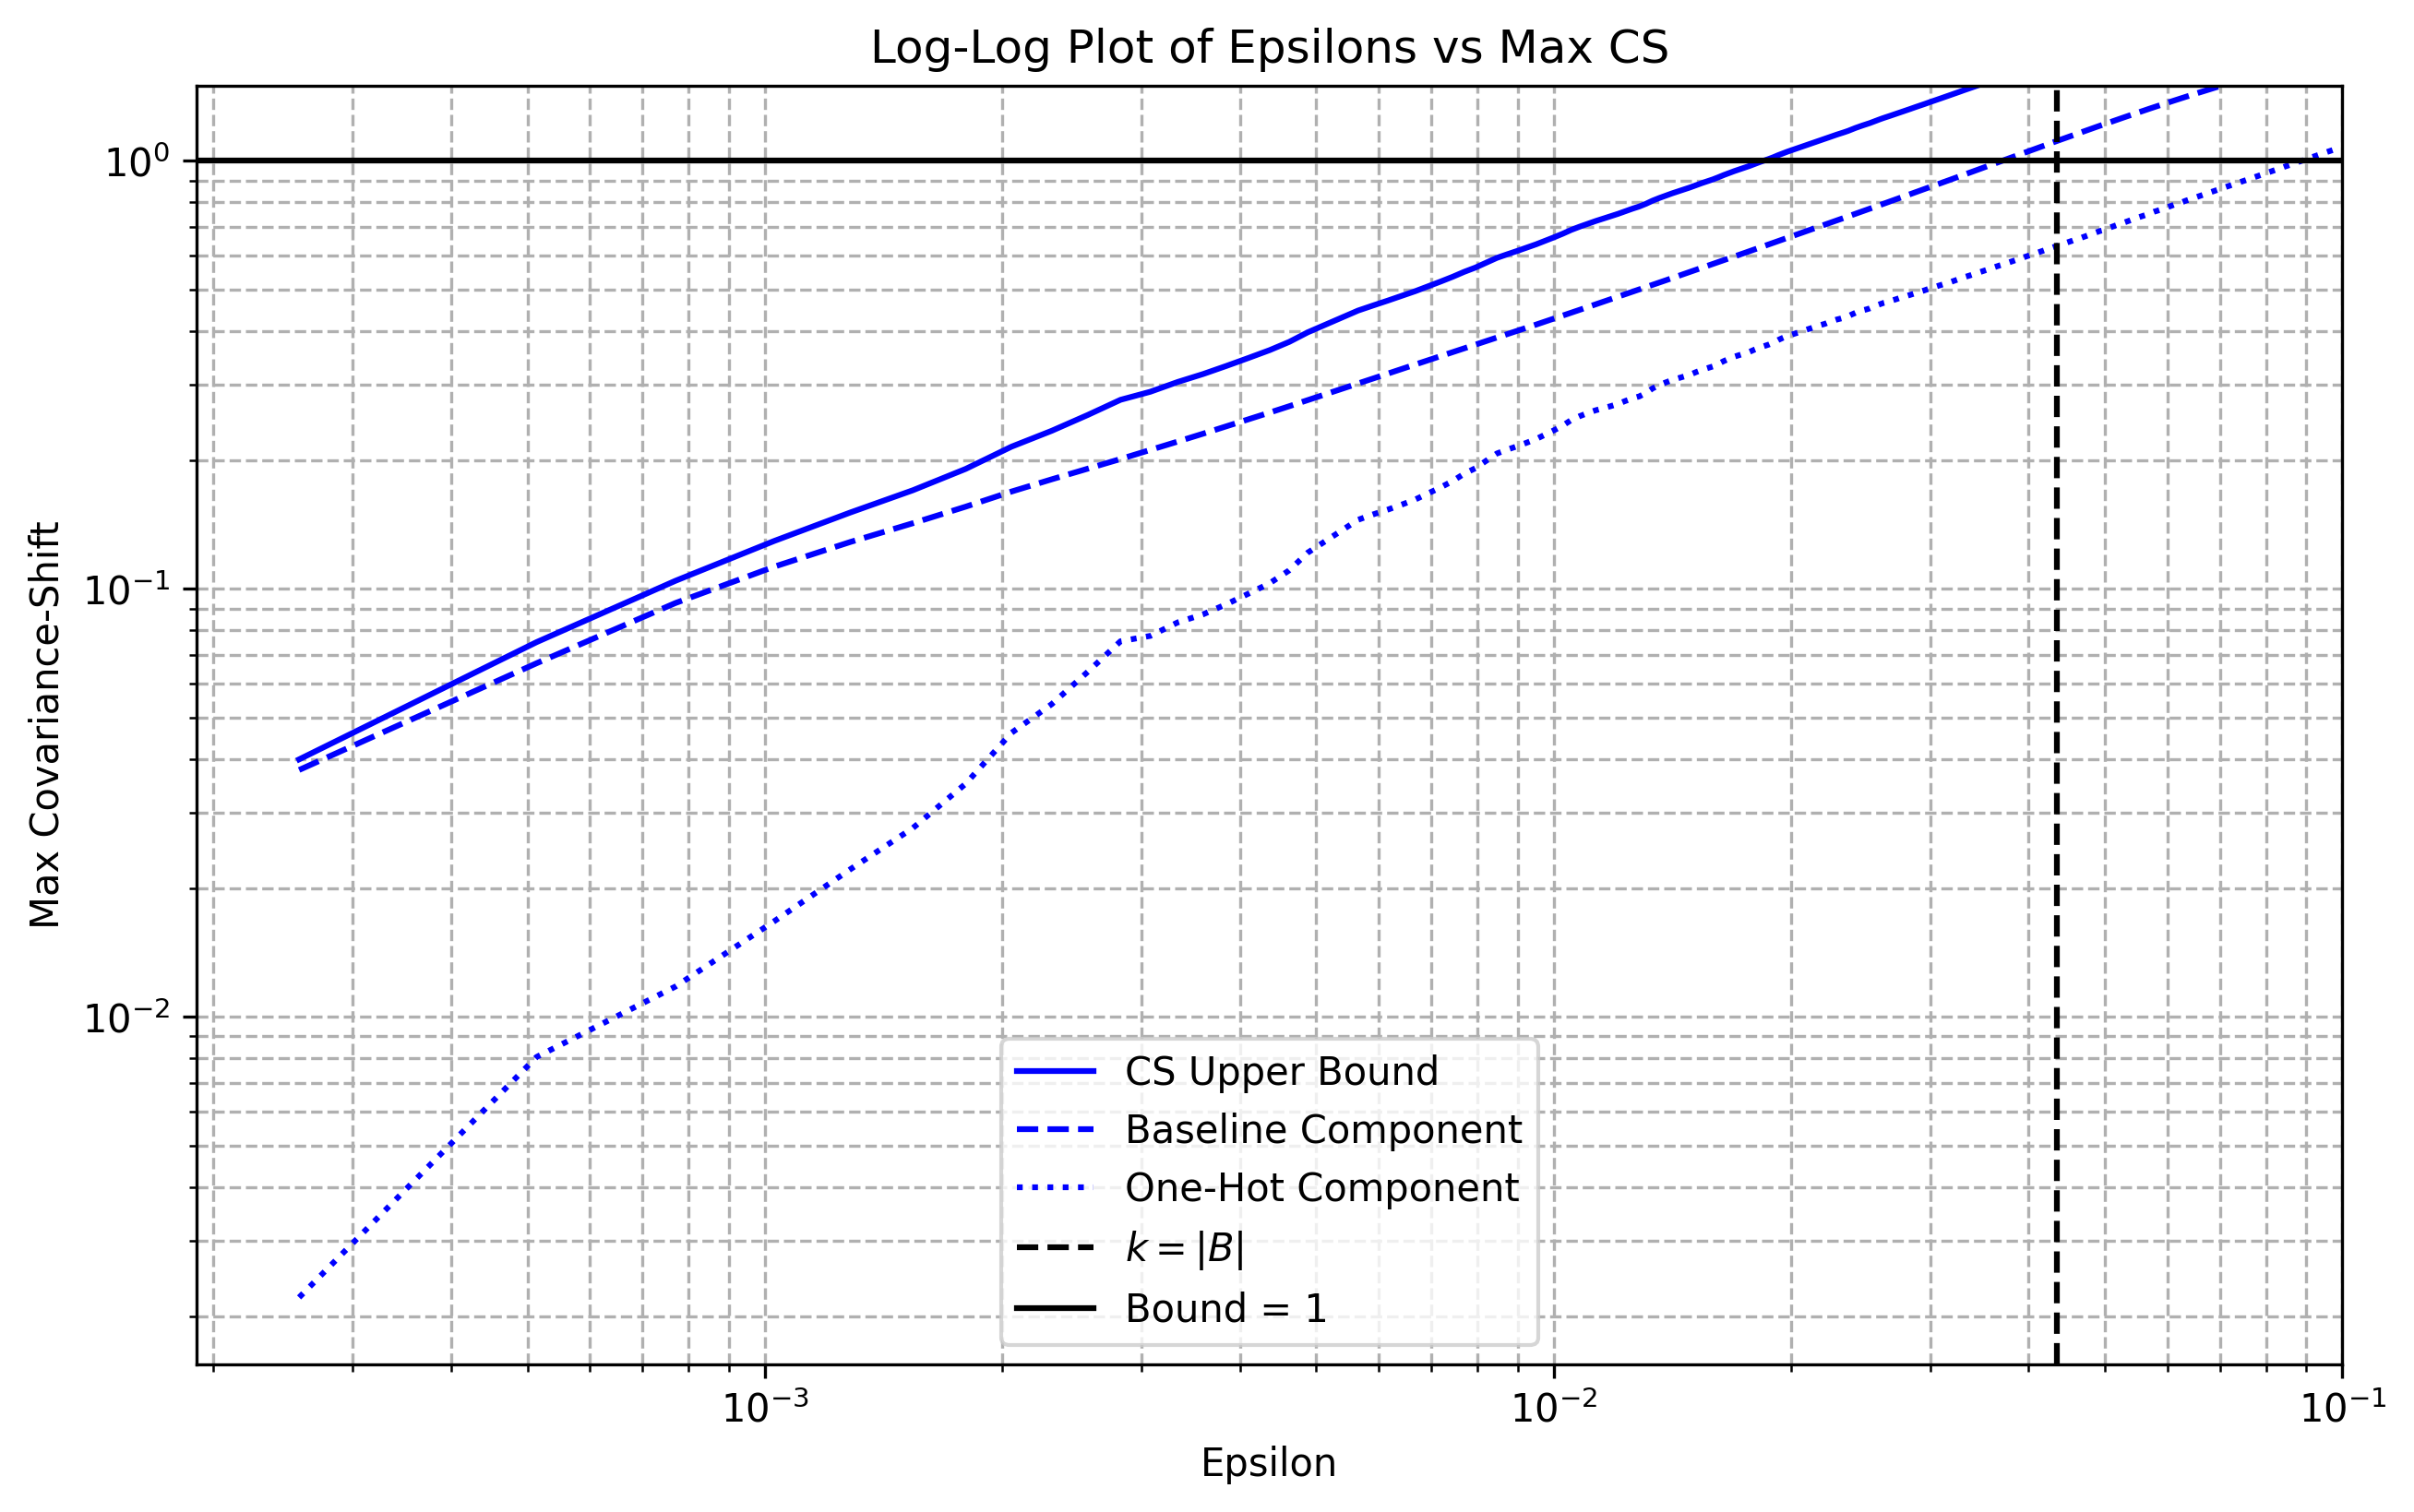

In [9]:
# Plot the resulting bounds on the covariance shift

plt.figure(figsize=(10, 6), dpi=300)
plt.loglog(epsilons, (ips_squared_bound_triangle[:len(ks)] + averaging_effect_CS_total[:len(ks)]), '-b', label='CS Upper Bound')

# plt.loglog(epsilons, CS_DP_bound[:len(ks)], '-r', label='New CS Upper Bound')

plt.loglog(epsilons, ips_squared_bound_triangle[:len(ks)], '--b', label='Baseline Component')

plt.loglog(epsilons, averaging_effect_CS_total[:len(ks)], ':b', label='One-Hot Component')

# plt.axvline(x=1/np.sqrt(num_samples*np.log(num_samples)), color='r', linestyle='--', label=r'$\varepsilon = \frac{1}{\sqrt{n \log(n)}}$')
plt.axvline(x=169/num_samples, color='k', linestyle='--', label=r'$k = |B|$')

plt.axhline(y=1, color='k', linestyle='-', label=r'Bound = 1')


plt.xlabel('Epsilon')
plt.ylabel('Max Covariance-Shift')
plt.title('Log-Log Plot of Epsilons vs Max CS')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.ylim(plt.ylim()[0], 1.5)
plt.xlim(plt.xlim()[0], 0.1)
plt.show()

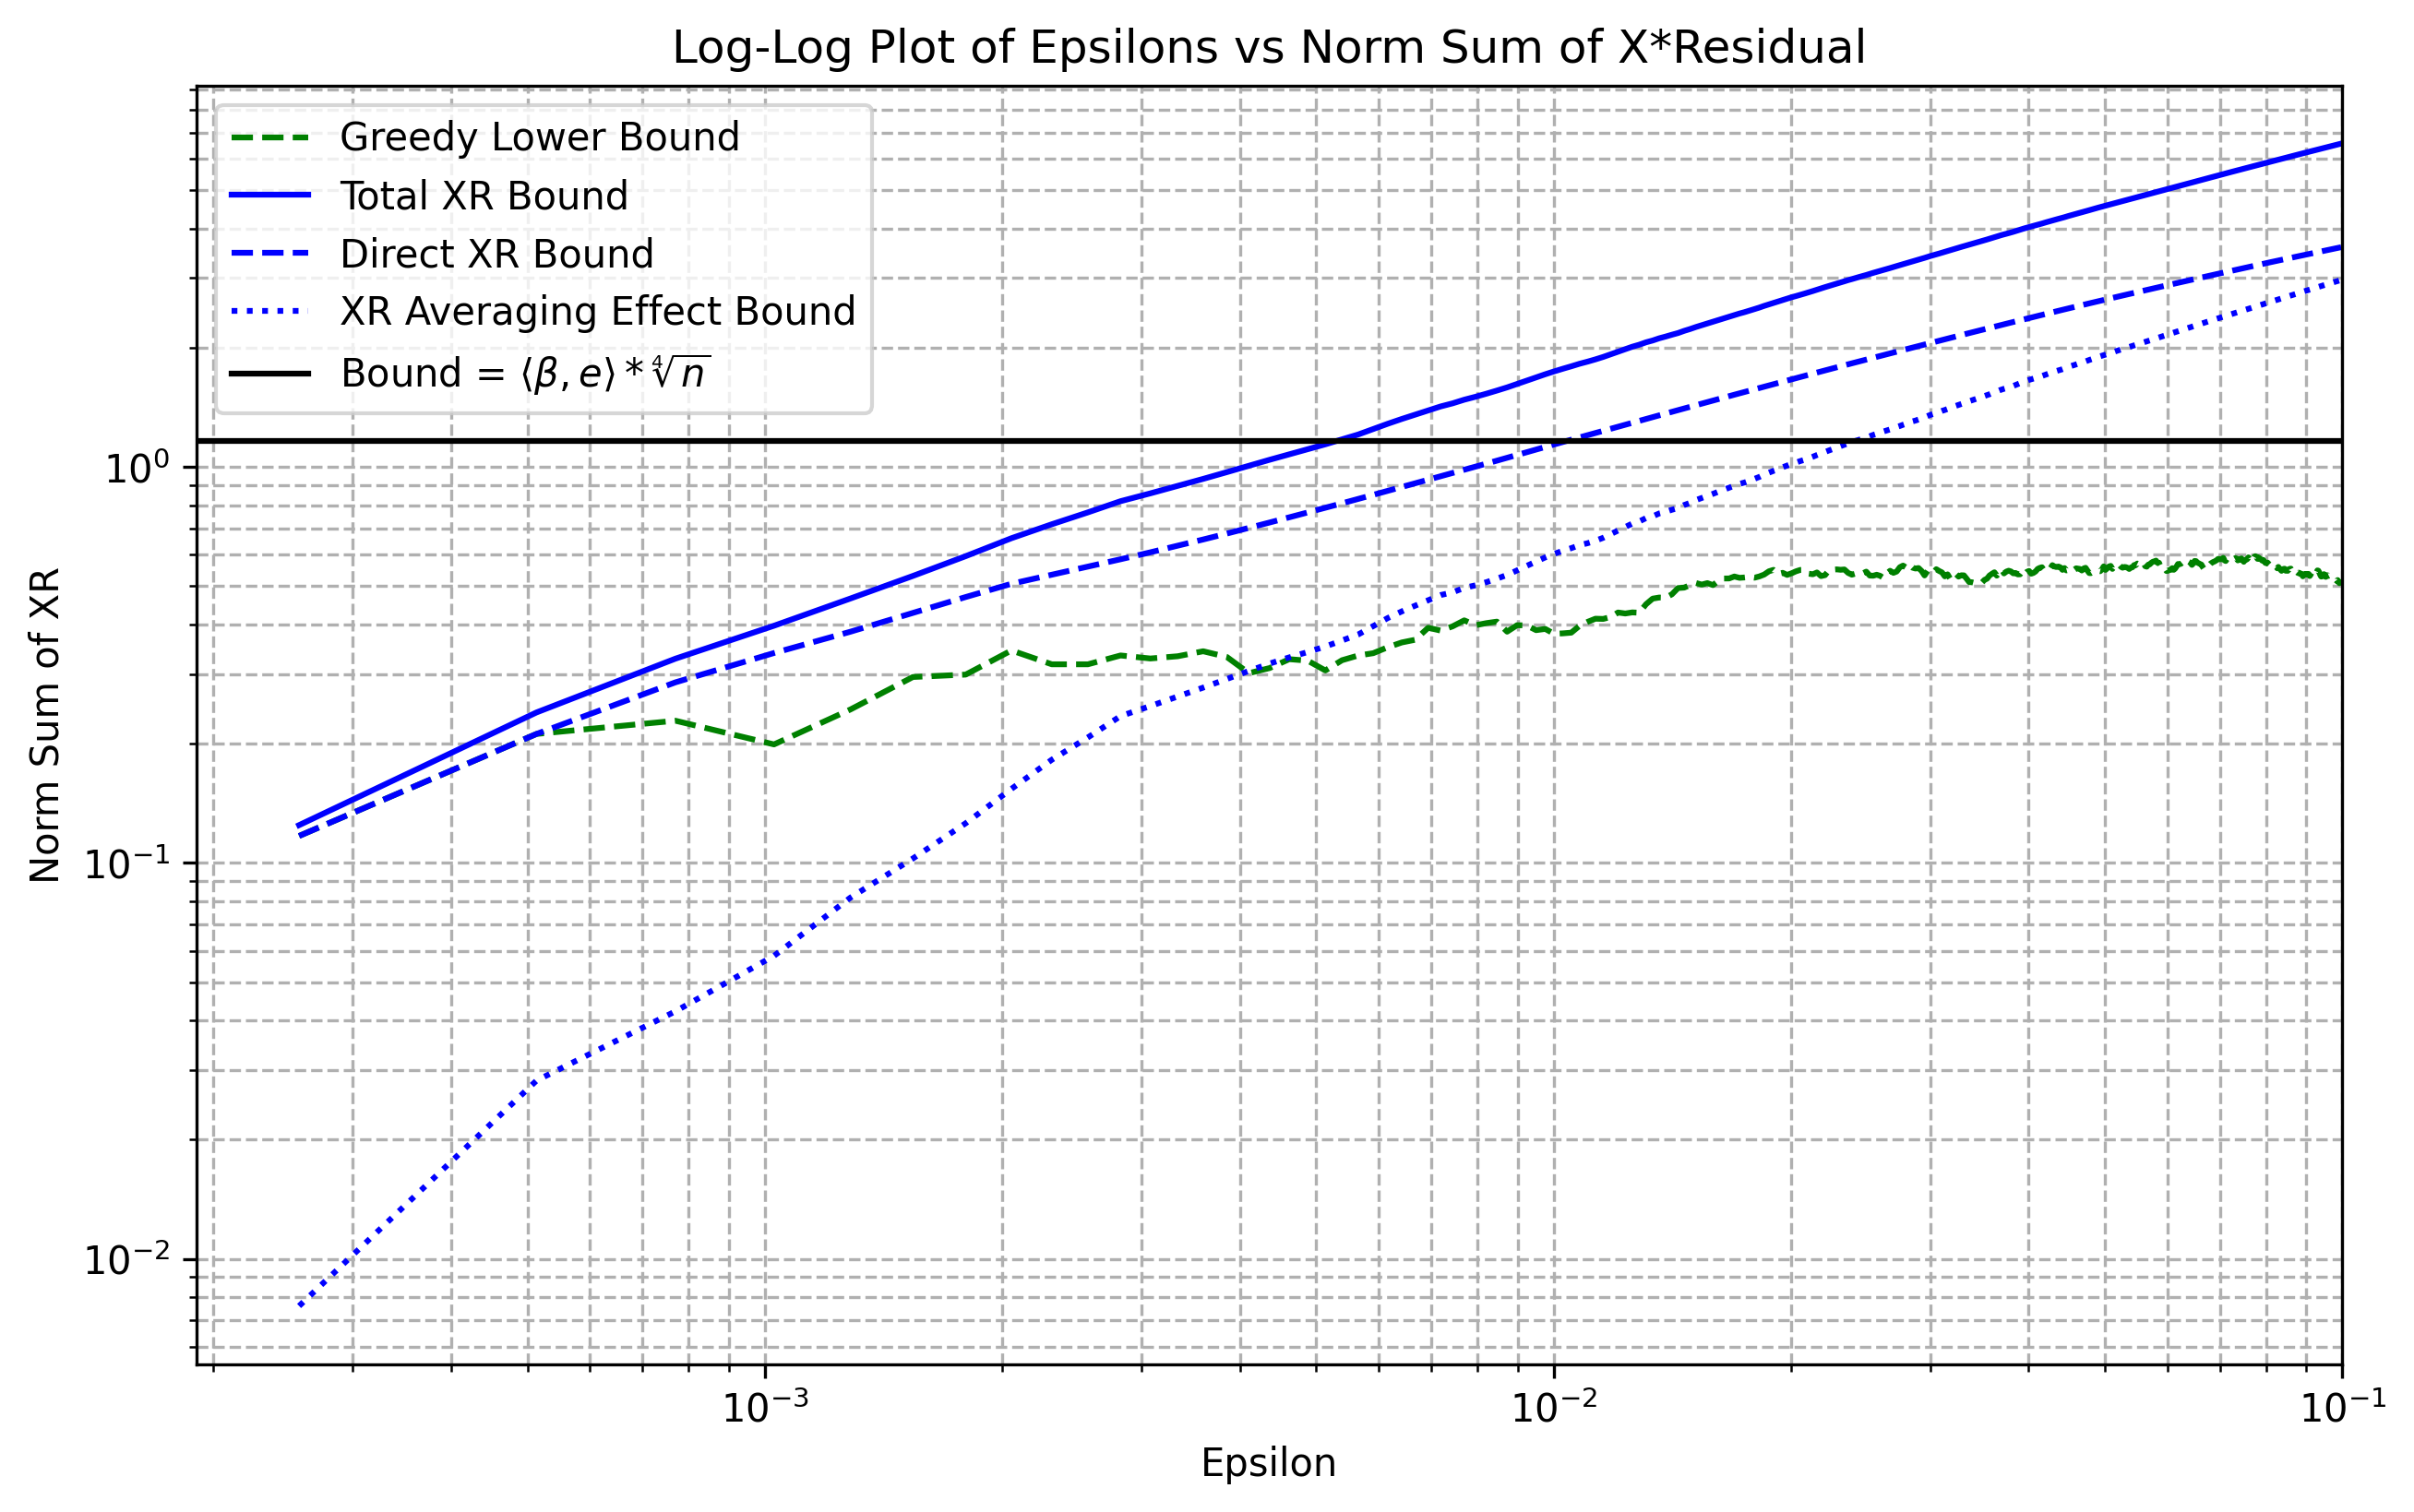

In [10]:
plt.figure(figsize=(10, 6), dpi=300)
diag_order = np.argsort(np.diag(gram_matrix_XR))[::-1]
plt.loglog(epsilons, np.linalg.norm(np.cumsum(XR[diag_order[:len(epsilons)], :], axis=0), axis=1) , '--g', label='Greedy Lower Bound')
plt.loglog(epsilons, (sum_ips_XR_triangle[:len(ks)] + averaging_effect_XR_total[:len(ks)]), '-b', label='Total XR Bound')

plt.loglog(epsilons, sum_ips_XR_triangle[:len(epsilons)], '--b', label='Direct XR Bound')

plt.loglog(epsilons, averaging_effect_XR_total[:len(epsilons)], ':b', label='XR Averaging Effect Bound')

plt.axhline(y=np.sqrt(np.abs(beta_e))*(num_samples ** 0.25), color='k', linestyle='-', label=r'Bound = $\langle \beta, e \rangle * \sqrt[4]{n}$')

plt.xlabel('Epsilon')
plt.ylabel('Norm Sum of XR')
plt.title('Log-Log Plot of Epsilons vs Norm Sum of X*Residual')
plt.grid(True, which="both", ls="--")
plt.legend()
# plt.ylim(1E-3, 1.5)
plt.xlim(plt.xlim()[0], 0.1)
plt.show()

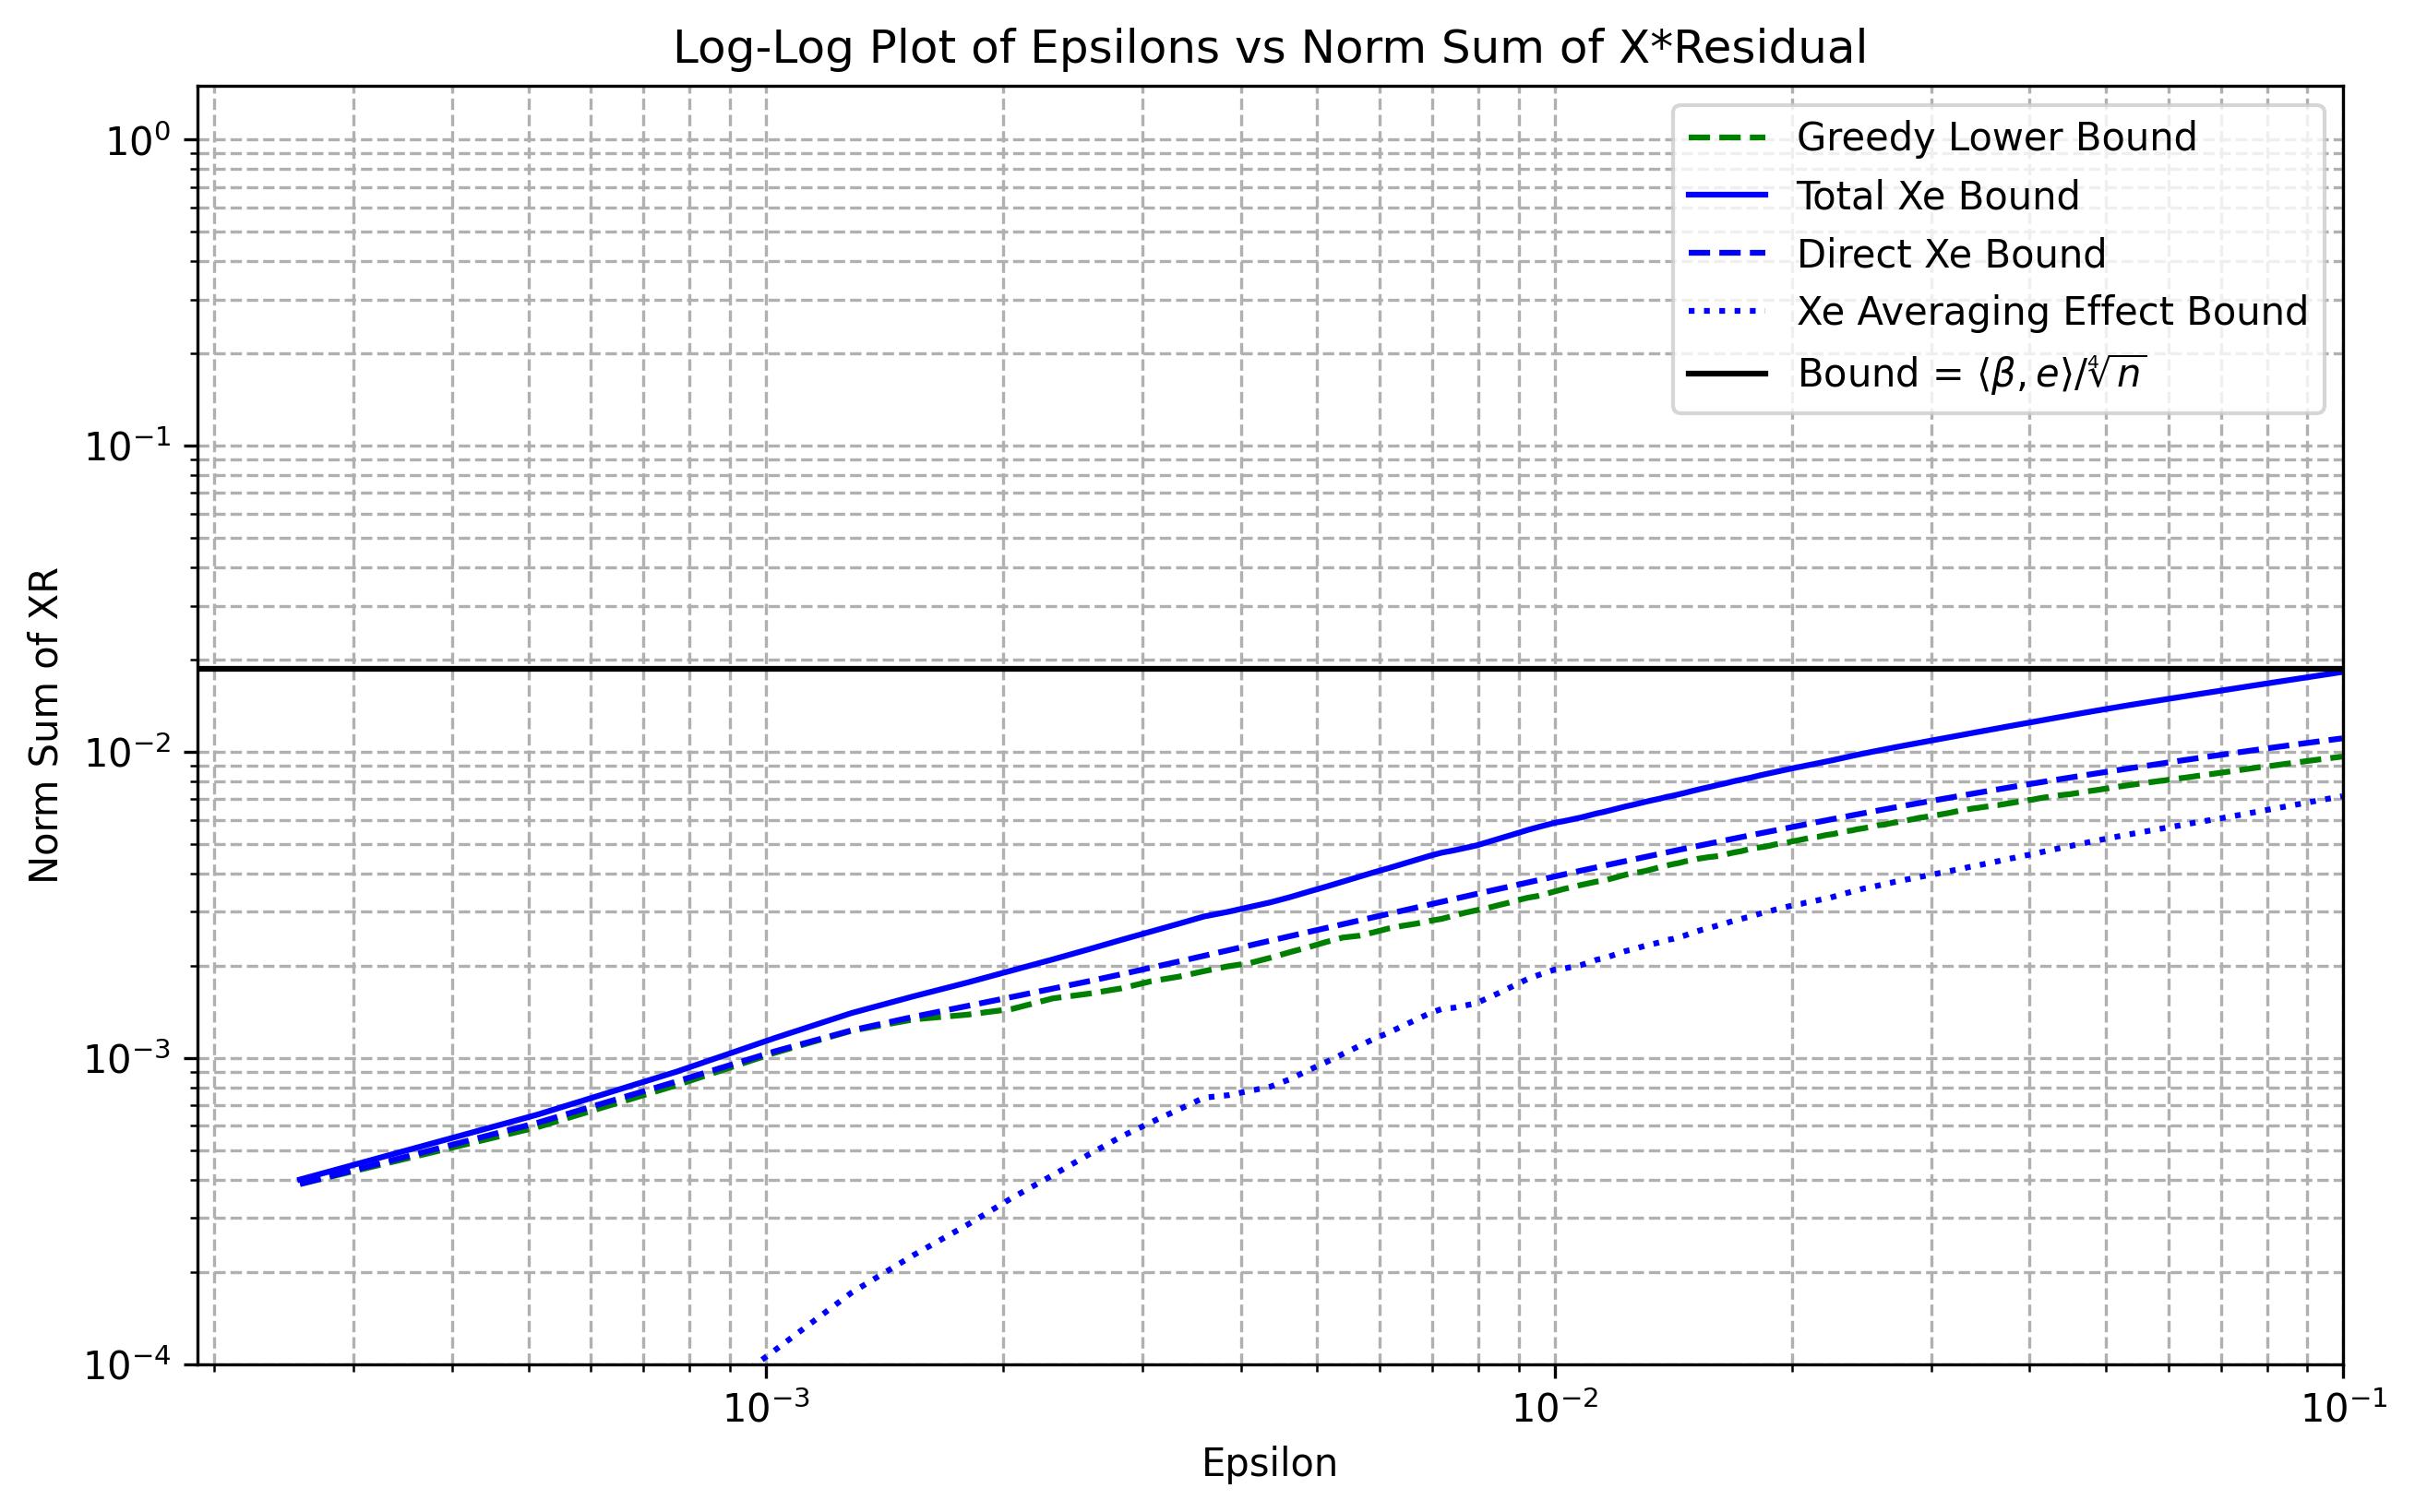

In [11]:
plt.figure(figsize=(10, 6), dpi=300)
diag_order = np.argsort(np.diag(gram_matrix_Xe))[::-1]
plt.loglog(epsilons, np.linalg.norm(np.cumsum(XZ[diag_order[:len(epsilons)], :], axis=0), axis=1), '--g', label='Greedy Lower Bound')
plt.loglog(epsilons, (sum_ips_Xe_triangle[:len(ks)] + averaging_effect_Xe_total[:len(ks)]), '-b', label='Total Xe Bound')

plt.loglog(epsilons, sum_ips_Xe_triangle[:len(epsilons)], '--b', label='Direct Xe Bound')

plt.loglog(epsilons, averaging_effect_Xe_total[:len(epsilons)], ':b', label='Xe Averaging Effect Bound')
plt.axhline(y=np.sqrt(np.abs(beta_e))/(num_samples ** 0.25), color='k', linestyle='-', label=r'Bound = $\langle \beta, e \rangle / \sqrt[4]{n}$')

plt.xlabel('Epsilon')
plt.ylabel('Norm Sum of XR')
plt.title('Log-Log Plot of Epsilons vs Norm Sum of X*Residual')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.ylim(1E-4, 1.5)
plt.xlim(plt.xlim()[0], 0.1)
plt.show()

In [12]:
# CS_bound = 2*ips_squared_bound_triangle[:num_samples-1]
CS_bound = (ips_squared_bound_triangle[:len(ks)] + averaging_effect_CS_total[:len(ks)])
sum_ips_Xe_bound = sum_ips_Xe_triangle[:len(ks)] + averaging_effect_Xe_total[:len(ks)]
sum_ips_XR_bound = sum_ips_XR_triangle[:len(ks)] + averaging_effect_XR_total[:len(ks)]
covariance_bound = (1 / (1 - CS_bound)) * sum_ips_Xe_bound * sum_ips_XR_bound

In [13]:
import pickle
with open('../examples/freund_and_hopkins_martinez.pkl', 'rb') as f:
    freund_and_hopkins = pickle.load(f)
freund_and_hopkins_good = np.logical_and(freund_and_hopkins > 0, freund_and_hopkins < np.inf)

with open('../examples/geometric_bounds_martinez.pkl', 'rb') as f:
    geometric_bounds = pickle.load(f)

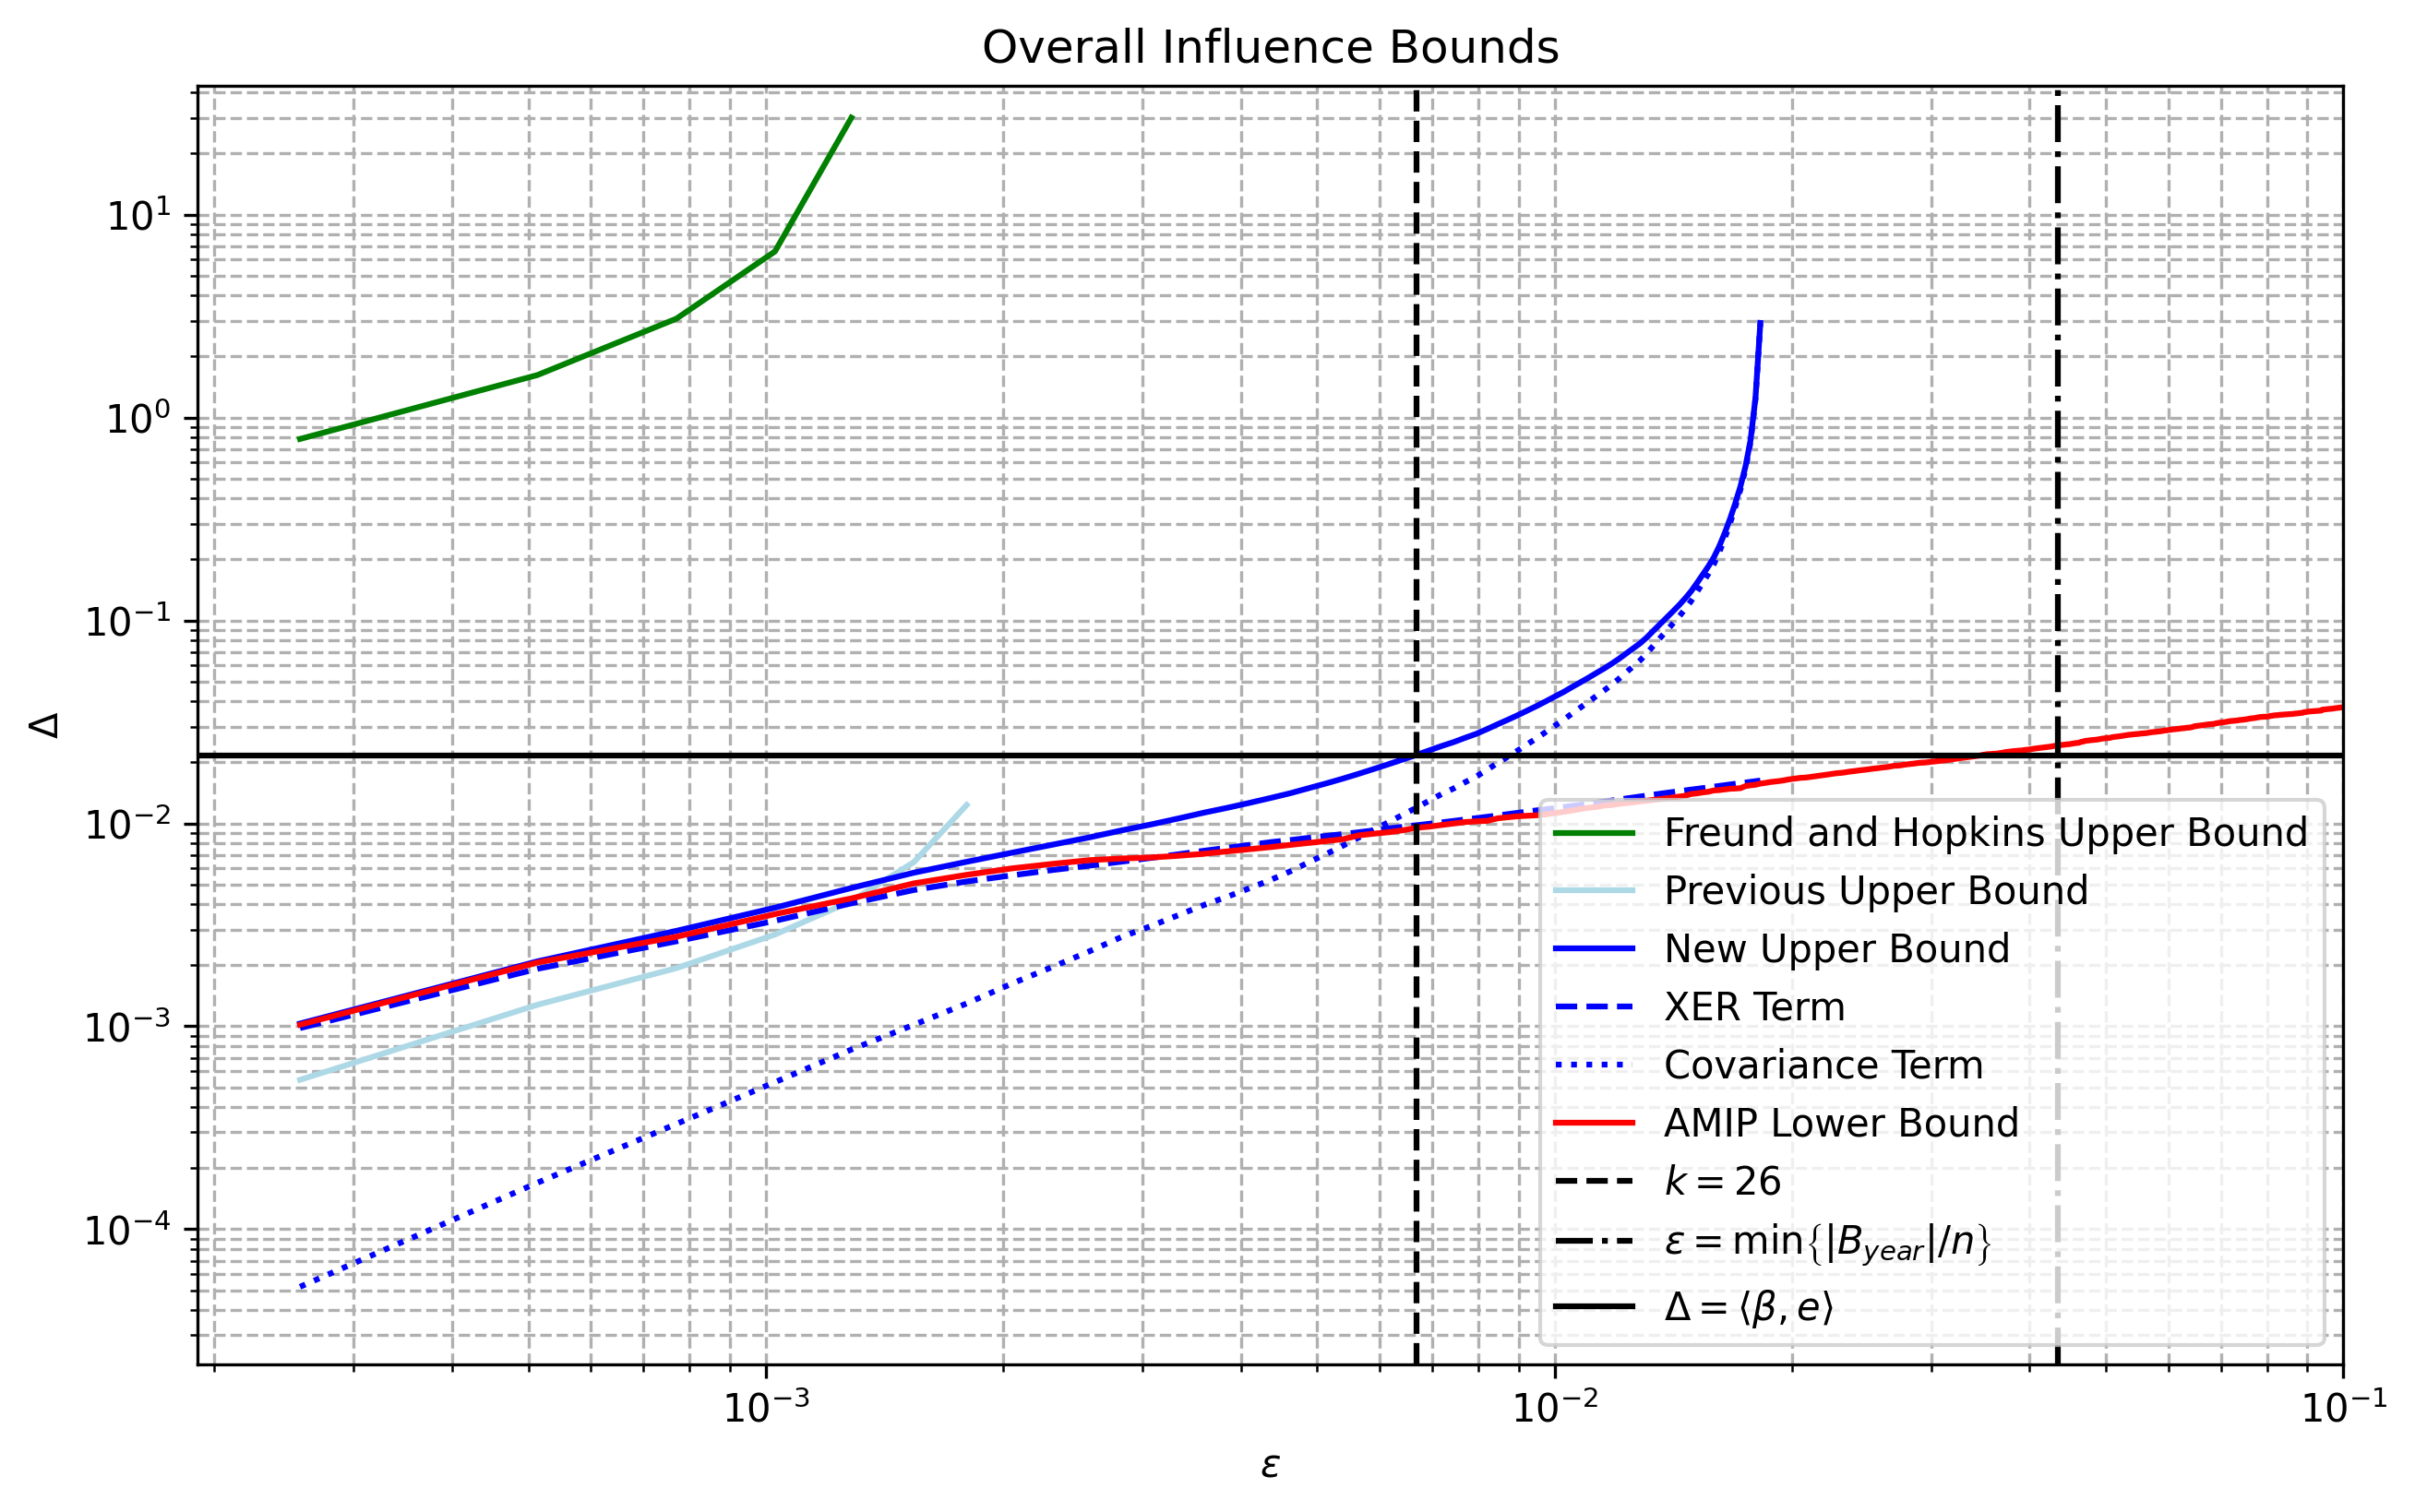

In [14]:
import matplotlib.pyplot as plt
# Plotting removal effects
plt.figure(dpi=300, figsize=(10, 6))
max_k = min(len(epsilons), len(covariance_bound))
plt.loglog(
    epsilons[freund_and_hopkins_good[:len(epsilons)]],
    freund_and_hopkins[freund_and_hopkins_good][:len(epsilons)], 
    '-g', label='Freund and Hopkins Upper Bound'
)

plt.loglog(
    epsilons[:len(geometric_bounds)],
    geometric_bounds,
    color='lightblue',  # Use 'color', not 'linecolor', and 'lightblue' (no hyphen)
    label='Previous Upper Bound'
)

plt.loglog(
    epsilons[CS_bound[:max_k] < 1],
    (total_score_bounds[:max_k] + covariance_bound[:max_k])[CS_bound[:max_k] < 1],
    '-b', label='New Upper Bound'
)

plt.loglog(
    epsilons[CS_bound[:max_k] < 1],
    (total_score_bounds[:max_k])[CS_bound[:max_k] < 1],
    '--b', label='XER Term'
)

plt.loglog(
    epsilons[CS_bound[:max_k] < 1],
    (covariance_bound[:max_k])[CS_bound[:max_k] < 1],
    ':b', label='Covariance Term'
)

plt.loglog(epsilons, removal_effect_amip, '-r', label='AMIP Lower Bound')

# plt.axvline(x=1/np.sqrt(num_samples*np.log(num_samples)), color='r', linestyle='--', label=r'$\varepsilon = \frac{1}{\sqrt{n \log(n)}}$')
plt.axvline(x=26 / num_samples, color='k', linestyle='--', label=r'$k=26$')
plt.axvline(x=169 / num_samples, color='k', linestyle='-.', label=r'$\varepsilon = \min \left\{ |B_{year}|/n \right\}$')

plt.axhline(y=np.abs(beta_e), color='k', linestyle='-', label=r'$\Delta = \langle \beta, e \rangle$')

plt.ylim(1E-3 * np.abs(beta_e), 2000 * np.abs(beta_e))
plt.xlim(plt.xlim()[0], 0.1)
plt.grid(True, which="both", ls="--")
# plt.grid(True, which="major", ls="-", color='k')
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$\Delta$')
plt.title('Overall Influence Bounds')
plt.legend(loc='lower right')
plt.savefig('martinez_one_hot.png')

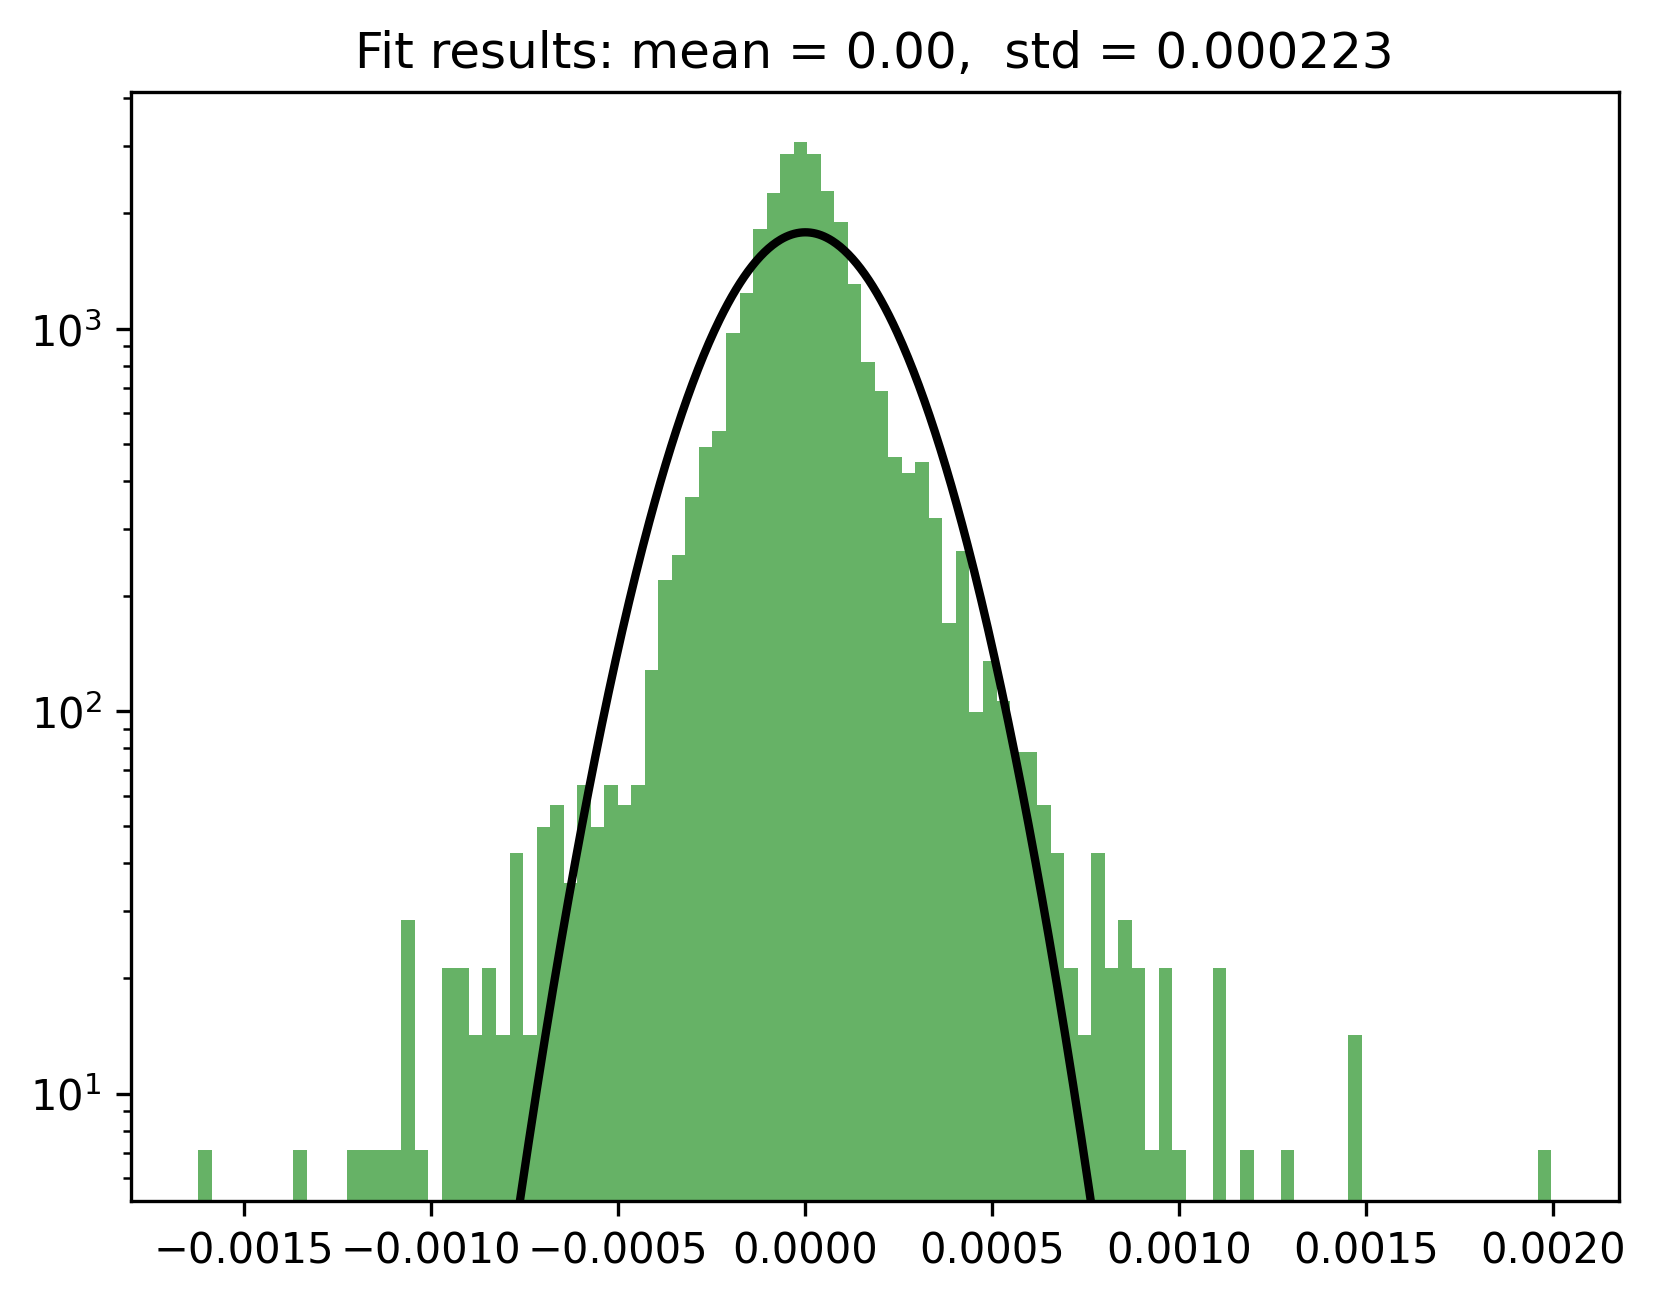

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming split_Z is defined and accessible
concatenated_Z = np.concatenate(split_Z)

# Step 1: Compute the histogram of concatenated_Z
plt.hist(concatenated_Z, bins=100, density=True, alpha=0.6, color='g')
plt.yscale('log')
ylim = plt.ylim()
# Step 2: Calculate the mean and variance of concatenated_Z
mean_Z = np.mean(concatenated_Z)
variance_Z = np.var(concatenated_Z)
sigma_Z = np.sqrt(variance_Z)  # Standard deviation

# Step 3: Generate a Gaussian distribution curve with the same mean and variance
x = np.linspace(min(concatenated_Z), max(concatenated_Z), 1000)
gaussian_curve = norm.pdf(x, mean_Z, sigma_Z)

# Step 4: Plot the histogram and Gaussian distribution curve
plt.plot(x, gaussian_curve, 'k', linewidth=2)
title = "Fit results: mean = %.2f,  std = %f" % (mean_Z, sigma_Z)
plt.title(title)

plt.ylim(ylim)

plt.show()


In [16]:
len(concatenated_Z)

3895